# How to use `quimb.tensor.TNOptimizer` directly

Quimb provides [a mechanism for optimizing tensor networks](https://quimb.readthedocs.io/en/latest/tensor-optimization.html) through its `TNOptimizer` interface.  The Quimb backend provided by this addon uses this under the hood. This how-to guide demonstrates how to work with this object directly, in case some users want more direct access to it.

### Set up a model Hamiltonian

In [1]:
from qiskit.transpiler import CouplingMap
from qiskit_addon_utils.problem_generators import generate_xyz_hamiltonian

# Generate some coupling map to use for this example
coupling_map = CouplingMap.from_heavy_hex(3, bidirectional=False)

# Choose a 10-qubit circle on this coupling map
reduced_coupling_map = coupling_map.reduce([0, 13, 1, 14, 10, 16, 4, 15, 3, 9])

# Get a qubit operator describing the Ising field model
hamiltonian = generate_xyz_hamiltonian(
    reduced_coupling_map,
    coupling_constants=(0.0, 0.0, 1.0),
    ext_magnetic_field=(0.4, 0.0, 0.0),
)

### Set up quimb simulator with default options

In [2]:
import quimb.tensor as qtn

from qiskit_addon_aqc_tensor.simulation.quimb import (
    QuimbSimulator,
    qiskit_ansatz_to_quimb,
    recover_parameters_from_quimb,
)

simulator = QuimbSimulator(qtn.Circuit)

### Generate target circuit

In [3]:
from qiskit.synthesis import SuzukiTrotter
from qiskit_addon_utils.problem_generators import generate_time_evolution_circuit

from qiskit_addon_aqc_tensor.simulation import (
    compute_overlap,
    tensornetwork_from_circuit,
)

evolution_time = 0.4

target_circuit = generate_time_evolution_circuit(
    hamiltonian,
    synthesis=SuzukiTrotter(reps=8),
    time=evolution_time,
)

target_tns = tensornetwork_from_circuit(target_circuit, simulator)

### Generate ansatz from a shallower circuit

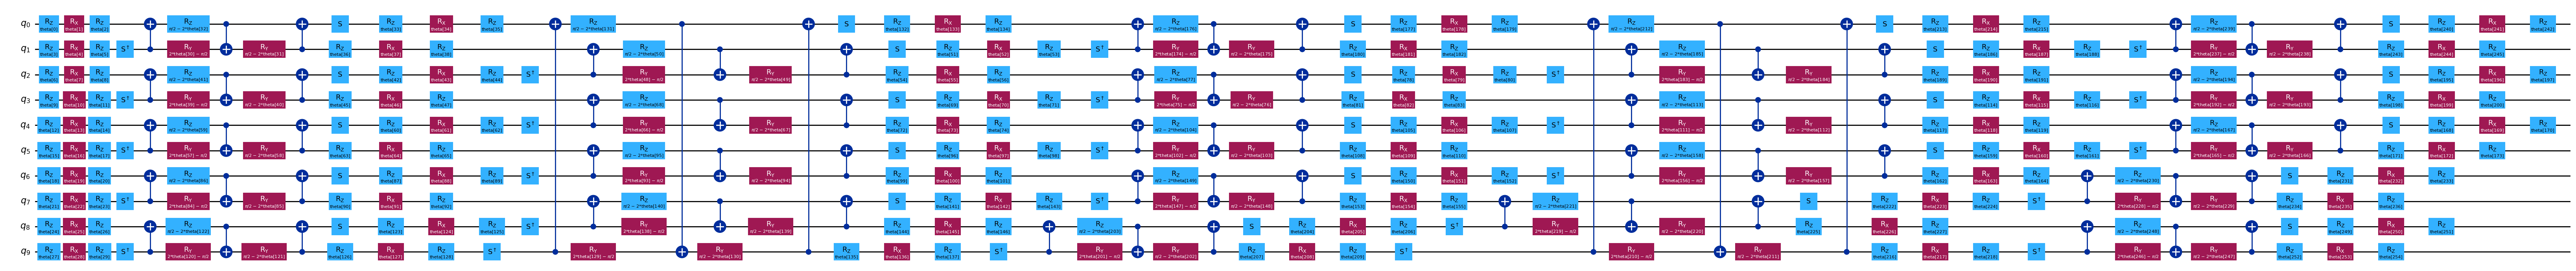

In [4]:
from qiskit_addon_aqc_tensor.ansatz_generation import (
    AnsatzBlock,
    generate_ansatz_from_circuit,
)

initial_shallow_circuit = generate_time_evolution_circuit(
    hamiltonian,
    synthesis=SuzukiTrotter(reps=2),
    time=evolution_time,
)
ansatz, initial_parameters = generate_ansatz_from_circuit(initial_shallow_circuit)
ansatz = ansatz.decompose(AnsatzBlock)
ansatz.draw("mpl", fold=-1)

### Initialize objective function

In [5]:
from qiskit_addon_aqc_tensor.objective import OneMinusFidelity

objective = OneMinusFidelity(target_tns, None, None)

### Convert Qiskit ansatz and initial parameters to a Quimb parametrized circuit

In [6]:
circ, conversion_context = qiskit_ansatz_to_quimb(ansatz, initial_parameters)

### Perform optimization of Quimb circuit using automatic differentiation

In [7]:
from qiskit_addon_aqc_tensor.simulation.quimb import tnoptimizer_objective_kwargs

tnopt = qtn.TNOptimizer(
    circ,
    **tnoptimizer_objective_kwargs(objective),
    autodiff_backend="jax",  # OPTIONS: jax, autograd, torch, etc.
)
circ_opt = tnopt.optimize(20)

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.
+0.000019788644 [best: +0.000019788644] : : 36it [00:50,  1.40s/it]                                                                                  


### Recover final parameters from the quimb circuit

In [8]:
final_parameters = recover_parameters_from_quimb(circ_opt, conversion_context)

### Check fidelity of final, compressed state w/ respect to target state

In [9]:
compressed_circuit = ansatz.assign_parameters(final_parameters)
compressed_state = tensornetwork_from_circuit(compressed_circuit, simulator)
abs(compute_overlap(target_tns, compressed_state)) ** 2

0.9999984444299815

### Compare with fidelity of initial shallow state w/ respect to target state

In [10]:
initial_shallow_state = tensornetwork_from_circuit(initial_shallow_circuit, simulator)
abs(compute_overlap(target_tns, initial_shallow_state)) ** 2

0.9998389457702321